In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

from matplotlib import pyplot as plt

In [2]:
class Mesh:
    def __init__(self):
        self.nodes_dict = {}   # Nodes dict <---> ID: [x y z]
        self.elems_dict = {}   # Elems dict <---> ID: [ne_1, ne_2, ...]
        self.N_nodes = 0
        self.N_elems = 0
        
    def read_mesh(self, mesh_name):
        # Reading nodes
        nodes_file = open(mesh_name + '_nodes.txt', 'r')
        
        for line in nodes_file:
            data_tokens = list(map(float, line.split(' ')))
            node_ID = int(data_tokens[0])
            coord_array = data_tokens[1:]
            self.nodes_dict[node_ID] = coord_array
            
        self.N_nodes = len(self.nodes_dict.keys())
        nodes_file.close()
        
        # Reading elems
        elems_file = open(mesh_name + '_elems.txt', 'r')
        
        for line in elems_file:
            if (line == ''):
                break
            data_tokens = list(map(int, line.replace(' \n', '').split(' ')))
            elem_ID = data_tokens[0]
            elem_nodes = data_tokens[1:]
            self.elems_dict[elem_ID] = elem_nodes
            
        self.N_elems = len(self.elems_dict.keys())
        elems_file.close()
        
        print(f'Mesh from [{mesh_name}] loaded.\n')
        print(f'Nodes: \t\t{self.N_nodes}')
        print(f'Elements: \t{self.N_elems}')
    
    def get_mesh(self):
        return self.nodes_dict, self.elems_dict

In [7]:
class FEM_matricies:
    def __init__(self, nodes_dict, elems_dict):
        self.nodes_dict = nodes_dict                    # Nodes dict <---> ID: [x y z]
        self.elems_dict = elems_dict                    # Elems dict <---> ID: [ne_1, ne_2, ...]
        
        self.N_nodes = len(nodes_dict.keys())
        self.N_elems = len(elems_dict.keys())
        
        self.N_dofs = self.N_nodes * 2                  # 2D case, DOFs along X and Y
        self.dofs_mapping = {}                          # Degrees of freedom for each element
        
        self.local_K = None                             # ToDo
        
    # For each element, calculates its nodes DOFs    
    def map_dofs(self):
        for elem in list(self.elems_dict.keys()):
            nodes = self.elems_dict[elem]
            dofs = []
            for node in nodes:
                dofs.append(2*(node-1))       # DOF along X
                dofs.append(2*(node-1) + 1)   # DOF along Y
            self.dofs_mapping[elem] = dofs
            
    def set_constants(self, young_E, poisson_NU):
        self.young_modulus = young_E
        self.possion_ratio = possion_NU
    
    # For triangular mesh
    def assemble_sparse_matrix(self):
        global_iK = np.zeros(36 * self.N_elems)
        global_jK = np.zeros(36 * self.N_elems)
        global_aK = np.zeros(36 * self.N_elems)
        
        for ei, elem in enumerate(list(self.elems_dict.keys())):
            iK = np.kron(self.dofs_mapping[elem], np.ones(8))
            jK = np.reshape(np.kron(self.dofs_mapping[elem], np.reshape(np.ones(8), (8,1))), -1)
            aK = np.reshape(self.local_K, -1)
            
            global_iK[36*ei : 36*(ei+1)] = iK
            global_jK[36*ei : 36*(ei+1)] = jK
            global_aK[36*ei : 36*(ei+1)] = aK
            
        self.sparse_matrix = sparse.coo_matrix((global_aK, (global_iK, global_jK)), shape = (self.N_dofs, self.N_dofs)).tocsr()
        
    def build_incidence_matrix(self):
        self.incidence_matrix = np.zeros((self.N_nodes, self.N_nodes))
        
        # Calculating incidence from elements
        for elem_ID in list(self.elems_dict.keys()):
            nodes = self.elems_dict[elem_ID]
            for i in range(len(nodes)):
                self.incidence_matrix[nodes[i]-1][nodes[i-1]-1] = 1                # Marking LEFT neighbor
                self.incidence_matrix[nodes[i]-1][nodes[(i+1)%len(nodes)]-1] = 1   # Marking RIGHT neighbor
                self.incidence_matrix[nodes[i]-1][nodes[i]-1] = 1                  # Marking node itself
                
    def draw_incidence_matrix(self):
        plt.figure(figsize=(7, 7))
        plt.imshow(self.incidence_matrix, cmap = 'magma')
        
    def get_incidence_matrix(self):
        return self.incidence_matrix

In [8]:
mesh = Mesh()
mesh.read_mesh('Mesh_1')

mesh_nodes, mesh_elems = mesh.get_mesh()

Mesh from [Mesh_1] loaded.

Nodes: 		221
Elements: 	364


In [9]:
f_matr = FEM_matricies(mesh_nodes, mesh_elems)
f_matr.build_incidence_matrix()

Incidence matrix:


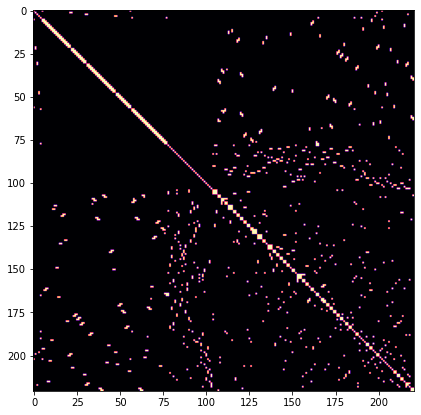

In [10]:
print('Incidence matrix:')
f_matr.draw_incidence_matrix()

In [11]:
f_matr.map_dofs()